In [1]:
# Import necessary libraries
from selenium import webdriver  # for web scraping using a browser
from bs4 import BeautifulSoup  # for parsing HTML content
import pandas as pd  # for data manipulation and handling
import time  # for adding delays in code execution
from tqdm import tqdm  # for displaying progress bars

In [2]:
# Initialize a Chrome WebDriver instance
browser = webdriver.Chrome()

In [3]:
# Prompt the user to input a YouTube channel name
channelName = input("Please enter a YouTube channel: ")

In [4]:
# Construct a Google search link for the input channel name
link = 'https://www.google.com/search?q=' + channelName + ' youtube'

In [5]:
# Open the constructed link in the browser
browser.get(link)

In [6]:
# Parse the HTML content of the page
soup = BeautifulSoup(browser.page_source, 'html.parser')

In [7]:
# Extract the link of the first search result (which is assumed to be the channel link)
for i in soup.find_all('div', class_='MjjYud'):
    link = i.find('a').get('href')
    break

In [8]:
# Open the channel's videos page in the browser
browser.get(link + '/' + 'videos')

In [9]:
# Parse the HTML content of the page
soup = BeautifulSoup(browser.page_source, 'html.parser')

In [10]:
# Scroll down the page to load more videos dynamically
for i in tqdm(range(0, 5000, 1000)):
    browser.execute_script('window.scrollTo(0,' + str(i) + ')')
    time.sleep(0.1)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  6.05it/s]


In [11]:
# Parse the HTML content of the page after scrolling
soup = BeautifulSoup(browser.page_source, 'html.parser')

In [12]:
# Find all video items on the page
video_items = soup.find_all('ytd-rich-item-renderer')

In [14]:
# Iterate over each video item and extract relevant information
data = []
for item in video_items:
    link = "https://www.youtube.com/" + item.find('a', class_='yt-simple-endpoint focus-on-expand style-scope ytd-rich-grid-media').get('href')
    title = item.find('a', class_='yt-simple-endpoint focus-on-expand style-scope ytd-rich-grid-media').get('title')
    views = (item.find('span', class_="inline-metadata-item style-scope ytd-video-meta-block").text.split(" ")[0])
    upload_time = (item.find_all('span', class_="inline-metadata-item style-scope ytd-video-meta-block")[1].text)
    data.append([link, title, views, upload_time])

In [16]:
# Save the DataFrame to a CSV file with the channel name as filename
df=pd.DataFrame(data,columns=['Link','Title','Views','UploadTime'])

df.to_csv(channelName + '.csv', index=False)

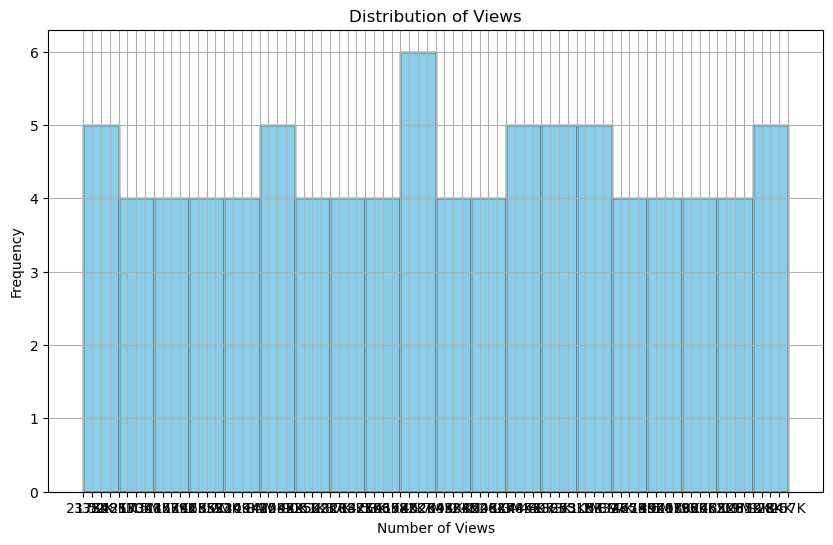

In [17]:
import matplotlib.pyplot as plt  # for visualization

# Plot a histogram of views
plt.figure(figsize=(10, 6))
plt.hist(df['Views'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Views')
plt.xlabel('Number of Views')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [52]:
import psycopg2
import os

try:
    # Connect to default PostgreSQL database
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="YOUR_PASSWORD_HERE",
        host="localhost",
        port="5432",
    )
except Exception as e:
    print(e)
    exit(0)

if conn is not None:
    print("Connection established to PostgreSQL.")

    # Create a cursor object
    cur = conn.cursor()

    # Check if the database exists
    cur.execute("SELECT 1 FROM pg_catalog.pg_database WHERE datname = 'youtube_videos'")
    if not cur.fetchone():
        # Close the cursor and connection
        cur.close()
        conn.close()

        # Reconnect to the default database without starting a transaction
        conn = psycopg2.connect(
            dbname="postgres",
            user="postgres",
            password="YOUR_PASSWORD_HERE",
            host="localhost",
            port="5432",
        )
        cur = conn.cursor()
        conn.autocommit = True

        # Create the database
        cur.execute("CREATE DATABASE youtube_videos")

    # Close the cursor and connection
    cur.close()
    conn.close()

    # Reconnect to the newly created database
    conn = psycopg2.connect(
        dbname="youtube_videos",
        user="postgres",
        password="YOUR_PASSWORD_HERE",
        host="localhost",
        port="5431",
    )
    cur = conn.cursor()

    # Create the table if it doesn't exist
    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS youtube_videos (
            id SERIAL PRIMARY KEY,
            link VARCHAR,
            title VARCHAR,
            views VARCHAR,
            upload_time VARCHAR
        )
    """
    )

    # Commit the transaction
    conn.commit()
    
    print(data)

    # Insert data into the table
    for row in data:
        cur.execute(
            """
            INSERT INTO youtube_videos (link, title, views, upload_time)
            VALUES (%s, %s, %s, %s)
            """,
            row,
        )
        
        
        # To check if the data have been inserted successfully or not.
        # uncommen this.
        #if cur.rowcount == 1:
            #print("Insertion successful")
        #else:
            #print("Insertion failed")

    # Commit the transaction
    conn.commit()
    
    print("Data inserted successfully.")
    
    # Query the database table
    cur.execute("SELECT * FROM youtube_videos")
    rows = cur.fetchall()
    for row in rows:
        print(row)

    # Close the cursor and connection
    if cur:
        cur.close()
    if conn:
        conn.close()

else:
    print("Connection to PostgreSQL FAILED.")

connection to server at "localhost" (::1), port 5432 failed: FATAL:  password authentication failed for user "postgres"

Connection established to PostgreSQL.


InterfaceError: connection already closed

: 